In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import cv2

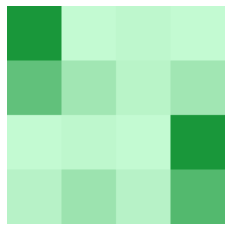

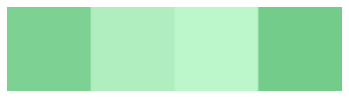

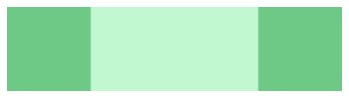

In [18]:
# for dummy attention
def imshow_attention(mat):
    if isinstance(mat, torch.Tensor):
        mat = mat.detach().cpu().numpy()
    mat = cv2.resize(mat, None, fx=32, fy=32, interpolation=cv2.INTER_NEAREST)
    H, W = mat.shape
    mat = mat.reshape(H, W, 1)
    high_color = np.array([10, 143, 45]).reshape(1,1,3)
    low_color = np.array([199, 252, 213]).reshape(1,1,3)
    mat = mat*high_color + (1-mat)*low_color
    mat = mat.astype(np.uint8)
    plt.imshow(mat)
    # plt.yticks([])
    # plt.xticks([])
    plt.axis('off')
    plt.show()

score = torch.tensor([
    [5, 1, 2, 1],
    [3, 2, 1, 2],
    [1, 2, 1, 5],
    [1, 2, 1, 3],
], dtype=torch.float32)
prob = torch.softmax(score, dim=-1)
reduced_prob = torch.mean(prob, dim=0, keepdim=True)

imshow_attention(prob)
imshow_attention(reduced_prob)
imshow_attention(torch.mean(prob[[0,2],:], dim=0, keepdim=True))